In [28]:
from sklearn.preprocessing import MinMaxScaler 
from transformer_encoder_decoder_qr_model2 import TransformerEncoderDecoderQRModel2

from utils import *

import random 
import os
import sys 

In [29]:
nhead =  4      # number of heads in the multi-head attention models
d_model = 64 #32    # model dimension
d_hid = 128 #64      # dimension of the feedforward network model
nlayers = 2 #4   # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
dropout = 0.1   # dropout rate

input_length  = 4  # Number of data points in src
output_length = 4  # Number of data points in tgt
nfeatures  = 1     #=3 if using woy
batch_size = 16

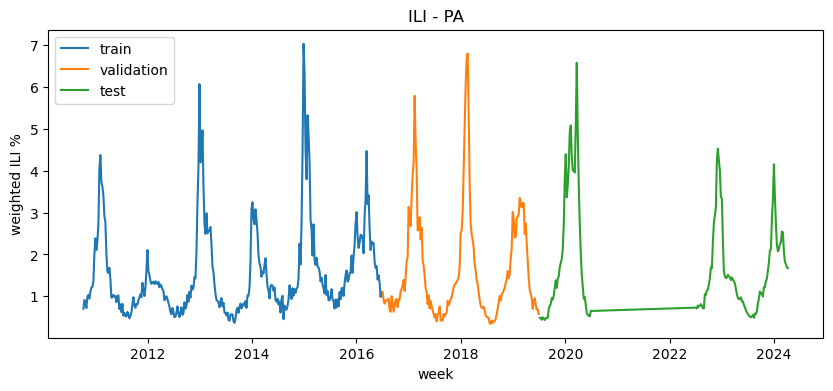

In [30]:
state = 'US'
ILI_df = load_ili_data(state)

start_val_date = pd.Timestamp('2014-07-01') #pd.Timestamp('2016-07-01') #pd.Timestamp('2016-07-01')
start_test_date = pd.Timestamp('2018-07-01') #pd.Timestamp('2019-07-01') #pd.Timestamp('2022-07-01') 

use_validation = True
if(use_validation):
    train_ind = np.where(ILI_df.index<start_val_date)[0] 
    val_ind = np.where((ILI_df.index>=start_val_date) & (ILI_df.index<start_test_date))
else:
    train_ind = np.where(ILI_df.index<start_test_date)[0]
    val_ind = []
# covid_ind = np.where((ILI_df.index>='2020-06-28') & (ILI_df.index<'2022-07-01'))
test_ind = np.where((ILI_df.index>=start_test_date))[0]

plt.figure(figsize=(10,4))
plt.plot(ILI_df.loc[ILI_df.iloc[train_ind].index,'weighted_ili'],label='train') 
if(use_validation):
    plt.plot(ILI_df.loc[ILI_df.iloc[val_ind].index,'weighted_ili'],label='validation') 
# plt.plot(ILI_df.loc[ILI_df.iloc[covid_ind].index,'weighted_ili'],label='throw (covid)') 
plt.plot(ILI_df.loc[ILI_df.iloc[test_ind].index,'weighted_ili'],label='test') 
plt.ylabel('weighted ILI %') 
plt.xlabel('week') 
plt.title('ILI - {}'.format(state)) 
plt.legend(loc=2)
plt.show()

In [31]:
ili = np.expand_dims(ILI_df['weighted_ili'].values,-1)
train_ili = ili[train_ind]
val_ili = ili[val_ind]
test_ili = ili[test_ind]

train_dates = ILI_df.index[train_ind]
val_dates = ILI_df.index[val_ind]
test_dates = ILI_df.index[test_ind]

scaler = MinMaxScaler() 
scaler.fit(train_ili)
train_data = scaler.transform(train_ili)
if(use_validation):
    val_data = scaler.transform(val_ili)
else:
    val_data = []
test_data = scaler.transform(test_ili)

print(len(train_data))
print(len(val_data))
print(len(test_data))

299
157
145


In [32]:
def get_data_loader2(ts_data, input_length, output_length, batch_size,
                    shuffle=True, drop_last=True):
    
    SOS = np.float32(-2) #0

    ix = range(0, len(ts_data) - input_length - output_length + 1)

    inputs = []
    targets = []

    for i in ix:
        input_sequence = ts_data[i:i+input_length]
        target_sequence = np.insert(ts_data[i+input_length:i+input_length+output_length],0,SOS)
        inputs.append(torch.from_numpy(input_sequence.astype(np.float32)))
        targets.append(torch.from_numpy(target_sequence.astype(np.float32)))

    # Convert lists to tensors
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)

    # Create dataset and dataloader
    dataset = TensorDataset(inputs, targets)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return (data_loader)

c:\Users\ry2460\anaconda3\envs\timeseries_forecasting\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 0: training loss: 1.7913, validation loss: 1.1288
epoch 1: training loss: 1.145, validation loss: 1.0262
epoch 2: training loss: 1.063, validation loss: 1.0328
epoch 3: training loss: 1.0316, validation loss: 1.0217
epoch 4: training loss: 0.9969, validation loss: 1.0214
epoch 5: training loss: 0.9902, validation loss: 1.0441
epoch 6: training loss: 0.9605, validation loss: 1.0167
epoch 7: training loss: 0.9664, validation loss: 1.0181
epoch 8: training loss: 0.9189, validation loss: 0.9696
epoch 9: training loss: 0.9047, validation loss: 0.9989
epoch 10: training loss: 0.8897, validation loss: 0.9379
epoch 11: training loss: 0.8544, validation loss: 0.7332
epoch 12: training loss: 0.7138, validation loss: 0.6582
epoch 13: training loss: 0.677, validation loss: 0.7974
epoch 14: training loss: 0.7087, validation loss: 0.6198
epoch 15: training loss: 0.6345, validation loss: 0.5714
epoch 16: training loss: 0.6396, validation loss: 0.5871
epoch 17: training loss: 0.6421, validation 

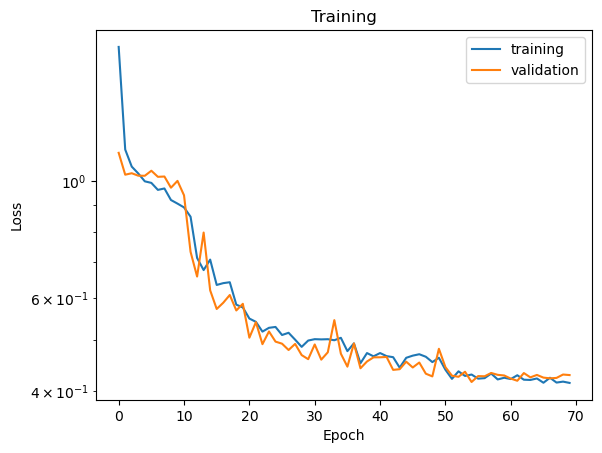

In [33]:
weeks_ahead = 1
training_loader  = get_data_loader2(train_data, input_length, output_length, batch_size)

random.seed(1) 
torch.manual_seed(1)

#initializing the model
model = TransformerEncoderDecoderQRModel2(nhead, d_model, d_hid, nlayers, input_length, output_length, nfeatures, nquantiles, dropout)
model = model.to(device)

#training
min_loss = sys.maxsize 
training_loss = [] 
if(use_validation):
    validation_loss = []
    val_loader  = get_data_loader2(val_data, input_length, output_length, batch_size)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3) 
    (model, optimizer, min_loss, training_loss, validation_loss) = \
        run_training_loop_with_validation(50, optimizer, model, min_loss, 
                                          training_loss, validation_loss, training_loader, val_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4) 
    (model, optimizer, min_loss, training_loss, validation_loss) = \
        run_training_loop_with_validation(10, optimizer, model, min_loss, 
                                          training_loss, validation_loss, training_loader, val_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5) 
    (model, optimizer, min_loss, training_loss, validation_loss) = \
        run_training_loop_with_validation(10, optimizer, model, min_loss, 
                                          training_loss, validation_loss, training_loader, val_loader)
else:
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3) 
    (model, optimizer, min_loss, training_loss) = \
        run_training_loop(50, optimizer, model, min_loss, training_loss, training_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4) 
    (model, optimizer, min_loss, training_loss) = \
        run_training_loop(10, optimizer, model, min_loss, training_loss, training_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5) 
    (model, optimizer, min_loss, training_loss) = \
        run_training_loop(10, optimizer, model, min_loss, training_loss, training_loader)

#training progress
plot_training_progress = True
if(plot_training_progress):
    plt.figure()
    plt.title('Training') 
    plt.yscale('log') 
    plt.plot(training_loss, label = 'training') 
    if(use_validation):
        plt.plot(validation_loss, label = 'validation') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend() 
    plt.show()

In [34]:
print(min_loss)

0.4156410312652588


In [35]:
def get_model_pred2(data, model, input_length, output_length, batch_size, train):
    
    data_loader = get_data_loader2(data, input_length, output_length, batch_size,
                                  shuffle=False, drop_last=False)
    pred = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation, reduces memory and computation
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            tgt_input = target[:, :-1] 
            if(train):
                output = model(input, tgt_input)
            else: 
                output = model(input) 
            out = output.to('cpu').detach().numpy()
            pred.append(out)

    pred = np.concatenate(pred, axis=0)
    return pred

In [36]:
def get_ili_data_and_pred(pred, ili, dates):
    pred_ili = scaler.inverse_transform(pred)
    #slice ili and test_dates to same dates as pred dates
    ili_slice = ili[input_length:]
    ili_slice = ili_slice[:len(pred_ili)]
    dates_slice = dates[input_length:]
    dates_slice = dates_slice[:len(pred_ili)]
    return (pred_ili,ili_slice,dates_slice)

In [37]:
pred_train = get_model_pred2(train_data, model, input_length, output_length, batch_size, train=True)
pred_test = get_model_pred2(test_data, model, input_length, output_length, batch_size, train=False)

In [38]:
# for i in range(output_length):
#     weeks_ahead = i+1
#     pred_train1 = pred_train[:,i,:].squeeze()
#     pred_train_ili1, train_ili1, train_dates1 = get_ili_data_and_pred(pred_train1, train_ili, train_dates)
#     plot_pred_fit(pred_train_ili1, train_ili1, train_dates1, weeks_ahead, state)

In [41]:
pred_test

(138, 4, 23)

weeks_ahead=1 (length=138): WIS=0.178, Quantile loss=1.918
weeks_ahead=2 (length=138): WIS=0.182, Quantile loss=1.968
weeks_ahead=3 (length=138): WIS=0.182, Quantile loss=1.968
weeks_ahead=4 (length=138): WIS=0.182, Quantile loss=1.968


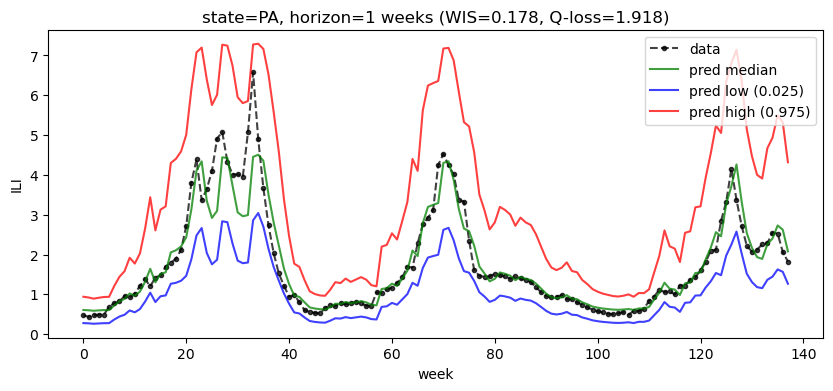

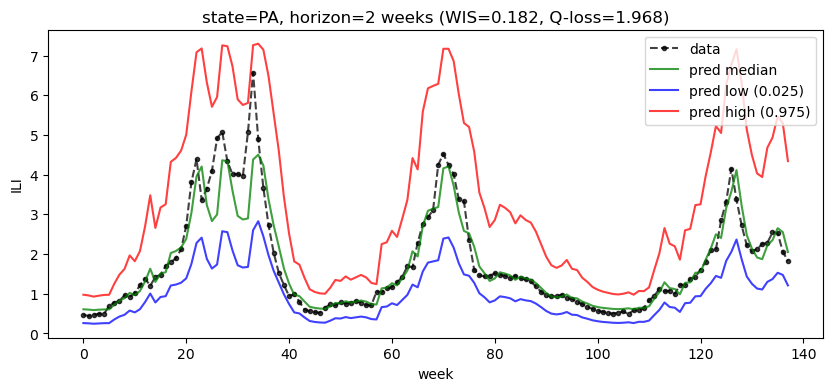

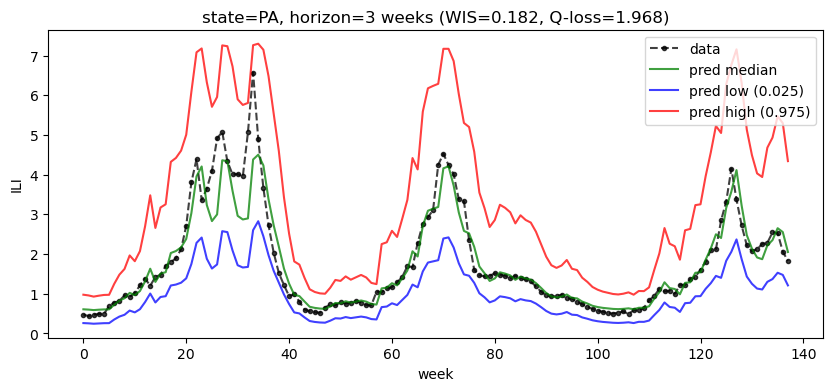

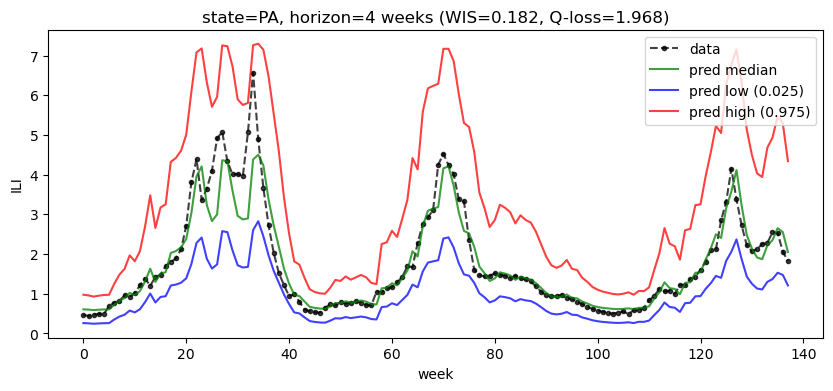

In [39]:
for i in range(output_length):
    weeks_ahead = i+1
    pred_test1 = pred_test[:,i,:].squeeze()
    pred_test_ili1, test_ili1, test_dates1 = get_ili_data_and_pred(pred_test1, test_ili, test_dates)
    plot_pred_fit(pred_test_ili1, test_ili1, test_dates1, weeks_ahead, state, use_dates_index=False)